In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [4]:
# Parameters
WINDOW_SIZE = 30
MAX_RUL = 125
ALERT_THRESHOLD = 25

# Load data
train_file = r"C:\Users\thumm\Downloads\archive (3)\CMaps\train_FD001.txt"
test_file = r"C:\Users\thumm\Downloads\archive (3)\CMaps\test_FD001.txt"
rul_file = r"C:\Users\thumm\Downloads\archive (3)\CMaps\RUL_FD001.txt"

cols = ['engine_id', 'cycle'] + [f'op_set_{i}' for i in range(1,4)] + [f'sensor_{i}' for i in range(1,22)]
df_train = pd.read_csv(train_file, sep=' ', header=None)
df_train.drop(df_train.columns[[26,27]], axis=1, inplace=True)
df_train.columns = cols

df_test = pd.read_csv(test_file, sep=' ', header=None)
df_test.drop(df_test.columns[[26,27]], axis=1, inplace=True)
df_test.columns = cols

df_rul = pd.read_csv(rul_file, sep=' ', header=None)
df_rul.dropna(axis=1, inplace=True)
df_rul.columns = ['RUL']

In [5]:
# Add RUL to training data
rul_train = df_train.groupby('engine_id')['cycle'].max().reset_index()
rul_train.columns = ['engine_id', 'max_cycle']
df_train = df_train.merge(rul_train, on='engine_id')
df_train['RUL'] = df_train['max_cycle'] - df_train['cycle']
df_train['RUL'] = df_train['RUL'].clip(upper=MAX_RUL)
df_train.drop('max_cycle', axis=1, inplace=True)

# Add RUL to test data
rul_list = []
for i, eid in enumerate(df_test['engine_id'].unique()):
    last_cycle = df_test[df_test['engine_id'] == eid]['cycle'].max()
    true_rul = df_rul.iloc[i]['RUL']
    for cycle in df_test[df_test['engine_id'] == eid]['cycle']:
        rul_list.append(true_rul + last_cycle - cycle)
df_test['RUL'] = rul_list
df_test['RUL'] = df_test['RUL'].clip(upper=MAX_RUL)

# Feature columns
features = [f'op_set_{i}' for i in range(1,4)] + [f'sensor_{i}' for i in range(1,22)]
df_train = df_train[['engine_id', 'cycle', 'RUL'] + features]
df_test = df_test[['engine_id', 'cycle', 'RUL'] + features]

# Normalize
scaler = MinMaxScaler()
df_train[features] = scaler.fit_transform(df_train[features])
df_test[features] = scaler.transform(df_test[features])

In [6]:
# Generate sequences
def generate_sequences(data, window):
    seq_X, seq_y = [], []
    for engine_id in data['engine_id'].unique():
        engine_data = data[data['engine_id'] == engine_id]
        for i in range(len(engine_data) - window + 1):
            window_data = engine_data.iloc[i:i+window]
            seq_X.append(window_data[features].values)
            seq_y.append(window_data.iloc[-1]['RUL'])
    return np.array(seq_X), np.array(seq_y)

X, y = generate_sequences(df_train, WINDOW_SIZE)
X_test, y_test = generate_sequences(df_test, WINDOW_SIZE)

In [7]:
# Split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [8]:
from tensorflow.keras.callbacks import EarlyStopping

# Model
input_layer = Input(shape=(WINDOW_SIZE, len(features)))
x = Conv1D(64, 3, activation='relu', padding='same')(input_layer)
x = MaxPooling1D(2)(x)
x = Bidirectional(LSTM(64, return_sequences=True))(x)
x = Bidirectional(LSTM(32))(x)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)
output = Dense(1)(x)
model = Model(inputs=input_layer, outputs=output)
model.compile(optimizer=Adam(1e-3), loss='mae')

# EarlyStopping callback
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# Train with EarlyStopping
model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=50,  # increased epochs to allow early stopping to decide
    batch_size=64,
    verbose=2,
    callbacks=[early_stop]
)


Epoch 1/50
222/222 - 37s - 165ms/step - loss: 48.2534 - val_loss: 36.3251
Epoch 2/50
222/222 - 12s - 53ms/step - loss: 24.9471 - val_loss: 16.7136
Epoch 3/50
222/222 - 12s - 54ms/step - loss: 16.8655 - val_loss: 14.6742
Epoch 4/50
222/222 - 12s - 55ms/step - loss: 14.9359 - val_loss: 12.1728
Epoch 5/50
222/222 - 12s - 54ms/step - loss: 12.4257 - val_loss: 10.4661
Epoch 6/50
222/222 - 12s - 55ms/step - loss: 11.8465 - val_loss: 10.4011
Epoch 7/50
222/222 - 12s - 53ms/step - loss: 11.6023 - val_loss: 9.6061
Epoch 8/50
222/222 - 12s - 54ms/step - loss: 11.1473 - val_loss: 9.3138
Epoch 9/50
222/222 - 13s - 56ms/step - loss: 11.1473 - val_loss: 9.4617
Epoch 10/50
222/222 - 12s - 54ms/step - loss: 11.0827 - val_loss: 10.2332
Epoch 11/50
222/222 - 12s - 54ms/step - loss: 10.9178 - val_loss: 9.6448
Epoch 12/50
222/222 - 12s - 55ms/step - loss: 10.6381 - val_loss: 8.7837
Epoch 13/50
222/222 - 12s - 54ms/step - loss: 10.5957 - val_loss: 10.2584
Epoch 14/50
222/222 - 12s - 56ms/step - loss: 10.65

In [9]:
# Evaluate
def evaluate_model(model, X, y, label):
    preds = model.predict(X).flatten()
    mae = np.mean(np.abs(preds - y))
    acc = 100 - (mae / MAX_RUL * 100)
    print(f"\n📊 {label} MAE: {mae:.2f}")
    print(f"✅ {label} Accuracy: {acc:.2f}%")
    return preds

y_train_pred = evaluate_model(model, X_train, y_train, "Train")
y_val_pred = evaluate_model(model, X_val, y_val, "Validation")
y_test_pred = evaluate_model(model, X_test, y_test, "Test")

444/444 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step

📊 Train MAE: 8.50
✅ Train Accuracy: 93.20%
111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step

📊 Validation MAE: 8.78
✅ Validation Accuracy: 92.97%
319/319 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step

📊 Test MAE: 9.11
✅ Test Accuracy: 92.72%


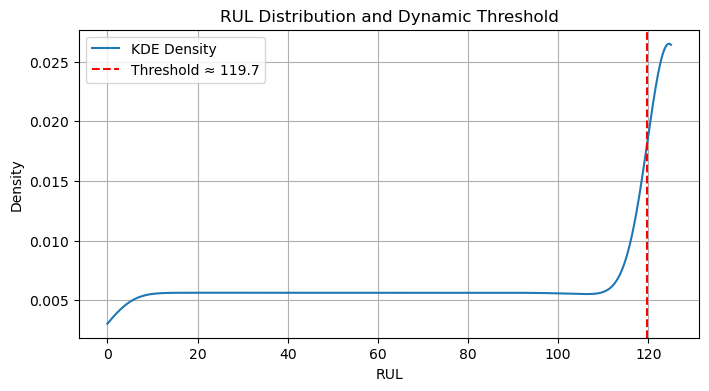

🔧 Estimated Dynamic RUL Threshold: 119.74


In [10]:
from sklearn.neighbors import KernelDensity
import numpy as np
import matplotlib.pyplot as plt

def estimate_dynamic_threshold(y_rul):
    # Reshape and fit KDE
    y_rul = np.array(y_rul).reshape(-1, 1)
    kde = KernelDensity(kernel='gaussian', bandwidth=5).fit(y_rul)

    # Create grid for RUL range
    x = np.linspace(min(y_rul)[0], max(y_rul)[0], 1000).reshape(-1, 1)
    log_density = kde.score_samples(x)
    density = np.exp(log_density)

    # Cumulative sum to approximate CDF
    cdf = np.cumsum(density)
    cdf = cdf / cdf[-1]  # normalize to [0,1]

    # Find inflection point = where second derivative is highest
    second_derivative = np.gradient(np.gradient(cdf))
    inflection_idx = np.argmax(second_derivative)
    threshold_rul = x[inflection_idx][0]

    # Plot (optional)
    plt.figure(figsize=(8, 4))
    plt.plot(x, density, label='KDE Density')
    plt.axvline(threshold_rul, color='red', linestyle='--', label=f"Threshold ≈ {threshold_rul:.1f}")
    plt.title("RUL Distribution and Dynamic Threshold")
    plt.xlabel("RUL")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True)
    plt.show()

    return threshold_rul

# Example usage inside your pipeline (after training)
dynamic_threshold = estimate_dynamic_threshold(y)
print(f"🔧 Estimated Dynamic RUL Threshold: {dynamic_threshold:.2f}")


In [11]:
#  Alert mechanism
alerts = y_test_pred < dynamic_threshold
for i in range(min(10, len(y_test))):
    print(f"Predicted: {y_test_pred[i]:.2f} | {'🚨 ALERT' if alerts[i] else '✅ OK'}")

# Save predictions
results_df = pd.DataFrame({'Actual_RUL': y_test, 'Predicted_RUL': y_test_pred})
results_df.to_csv(r"C:\Users\thumm\Downloads\archive (3)\CMaps\Predicted_RULs.csv", index=False)

Predicted: 118.69 | 🚨 ALERT
Predicted: 117.39 | 🚨 ALERT
Predicted: 115.58 | 🚨 ALERT
Predicted: 111.90 | 🚨 ALERT
Predicted: 105.49 | 🚨 ALERT
Predicted: 108.34 | 🚨 ALERT
Predicted: 118.58 | 🚨 ALERT
Predicted: 123.41 | ✅ OK
Predicted: 123.17 | ✅ OK
Predicted: 124.33 | ✅ OK


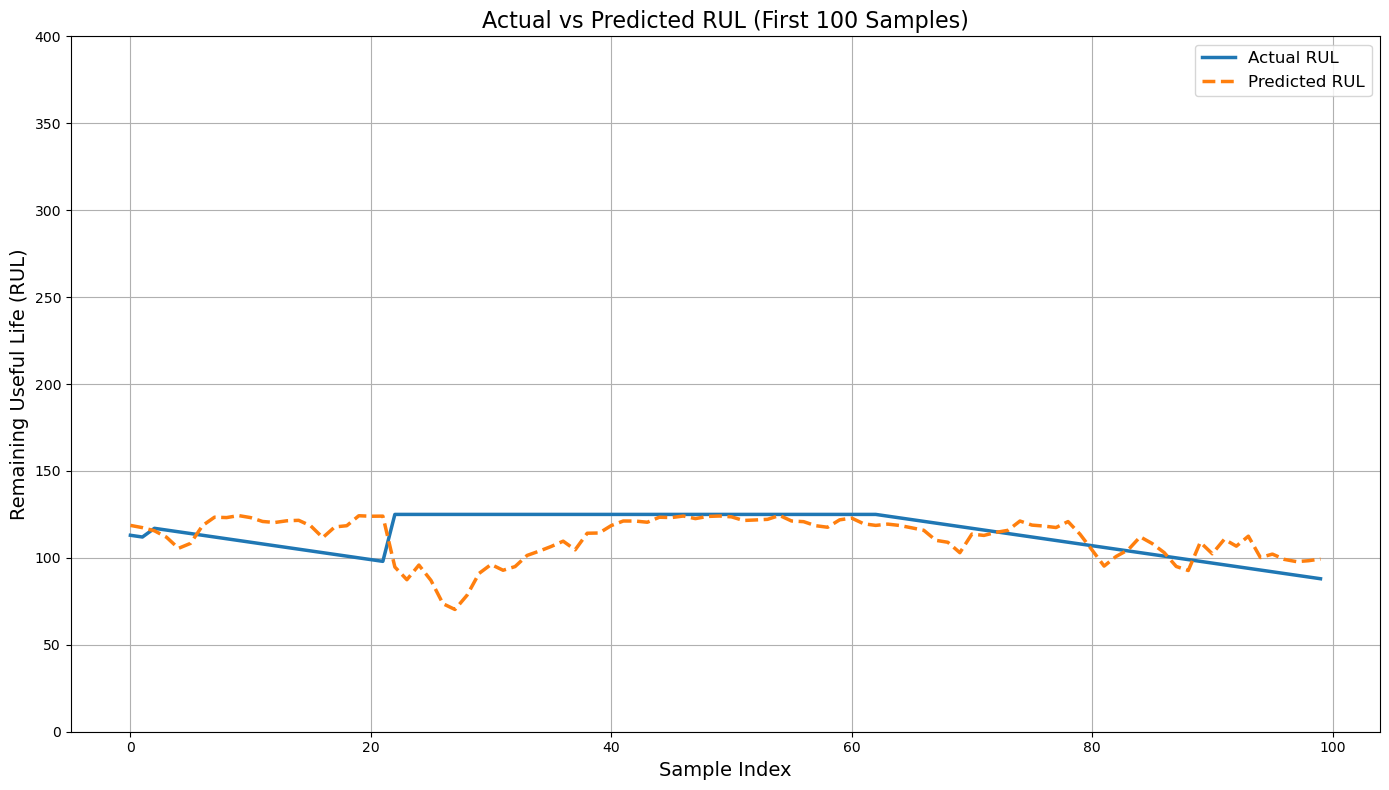

In [12]:
import matplotlib.pyplot as plt

# 🔍 Plot Actual vs Predicted RULs with Increased Y-Axis Scale
plt.figure(figsize=(14, 8))
plt.plot(y_test[:100], label='Actual RUL', linewidth=2.5)
plt.plot(y_test_pred[:100], label='Predicted RUL', linewidth=2.5, linestyle='--')
plt.title('Actual vs Predicted RUL (First 100 Samples)', fontsize=16)
plt.xlabel('Sample Index', fontsize=14)
plt.ylabel('Remaining Useful Life (RUL)', fontsize=14)
plt.ylim(0, 400)  # 🔼 Increase this upper limit based on your RUL values
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()


C:\ProgramData\anaconda3\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


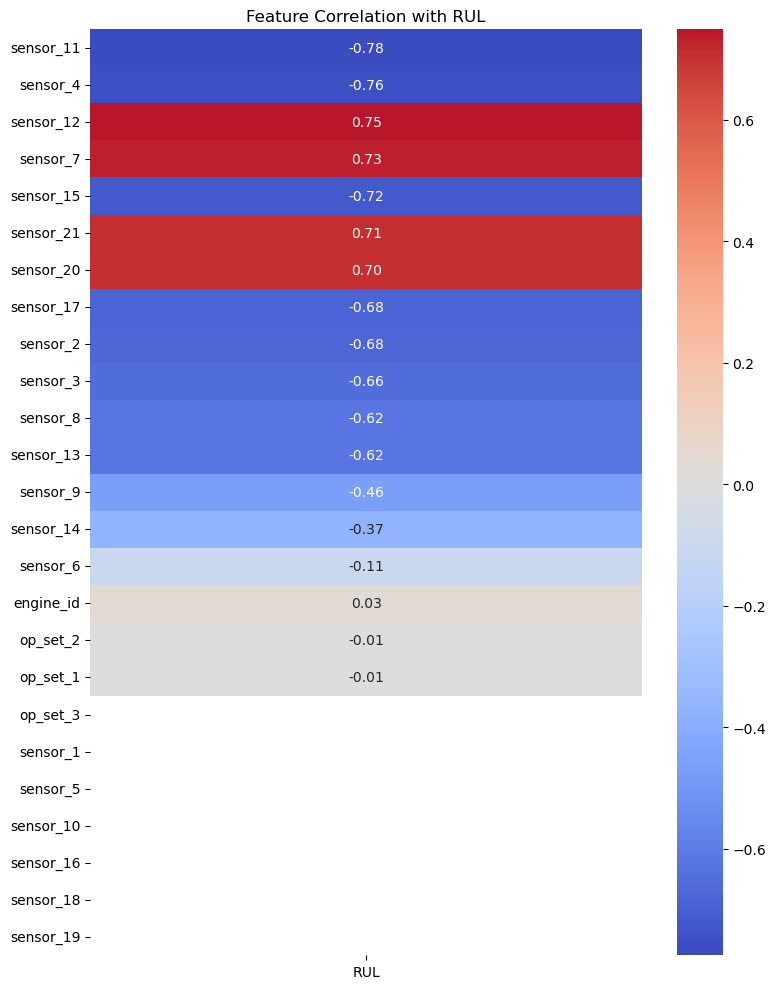

In [20]:
# # Feature correlation heatmap
# corr_matrix = pd.DataFrame(df_train[features + ['RUL']]).corr()
# plt.figure(figsize=(14, 10))
# sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', fmt='.2f')
# plt.title("Feature Correlation with RUL")
# plt.tight_layout()
# plt.show()

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df_train is your training DataFrame and RUL column is already added
# List of features (excluding non-sensor columns like 'unit', 'cycle', etc.)
features = [col for col in df_train.columns if col not in ['unit', 'cycle', 'RUL']]

# Calculate correlation with RUL
correlation_with_rul = df_train[features + ['RUL']].corr()['RUL'].drop('RUL')

# Sort by absolute correlation value (importance)
rul_corr_sorted = correlation_with_rul.reindex(correlation_with_rul.abs().sort_values(ascending=False).index)

# 🔥 Heatmap (Only correlation with RUL)
plt.figure(figsize=(8, len(rul_corr_sorted) * 0.4))
sns.heatmap(rul_corr_sorted.to_frame(), annot=True, cmap='coolwarm', center=0, fmt=".2f")
plt.title("Feature Correlation with RUL")
plt.tight_layout()
plt.show()


C:\Users\thumm\AppData\Local\Temp\ipykernel_36896\1030622970.py:9: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
C:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


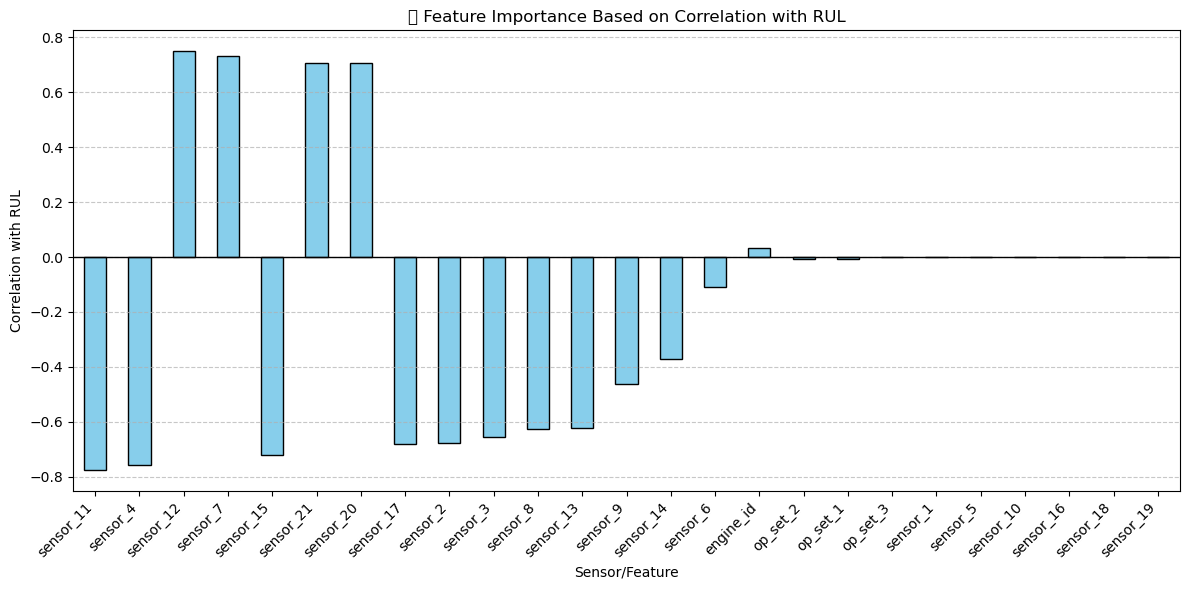

In [19]:
plt.figure(figsize=(12, 6))
rul_corr_sorted.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('📊 Feature Importance Based on Correlation with RUL')
plt.xlabel('Sensor/Feature')
plt.ylabel('Correlation with RUL')
plt.axhline(0, color='black', linewidth=1)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()